# Final Assignment - Machine Learning - 25th January 
## Ernests Kuznecovs
## 17332791    
   
# Question 1 

In [114]:
import json_lines
X=[]; y=[]; z=[]
with open ('reviews_291.jl', 'rb' ) as f:
  for item in json_lines.reader(f):
    X.append ( item [ 'text' ] )
    y.append ( item [ 'voted_up' ] )
    z.append ( item [ 'early_access' ] )

In [115]:
import pandas as pd
import numpy as np

text = pd.DataFrame(X)
votes = pd.DataFrame(y)
early = pd.DataFrame(z)

Used the approach of using external API provided by Google to detect the language. 

Decided to only use the text marked as english. But therefore only be able to predict english text.

Could also translated the other languages into english.

Could alternatively tried to group each language together based on the which reviews contained common words and  created a graph with connections. In the graph, a word would be a vertex, and an edge would indicate that one of the words in the document in which that word came from, also appeared in a different document. Words with high number of edges and that were highly connected to each other would be considered the same language.

On each language was isolated, a separate model could be used for each language, using a simple tokenizer that split on spaces for example.

Could remove the very low frequency words to prevent overfitting. And could remove high frequency words to that don't help to discriminate much.

If using a linear model, then could also discard words like "not" as a linear model wouldn't make much use of the word if it appeard the same times in both true and negative reviews. If using n-grams then words that negate would be a help as "not good" would be an example of a possible token used in the one-hot encoding.

In [167]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/ek/College/MachineLearning/Final/translate-302719-4cc72fc518f9.json'
USER = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
def detect_language(text):
    from google.cloud import translate_v2 as translate
    translate_client = translate.Client()
    result = translate_client.detect_language(text)
    return [text, result["language"], result["confidence"]]

Below is the code that retrieves the indices of the english documents in the set of documents. I had retrieved the first batch of language detections, (which I pickled) before realising that the reviews were sorted by their vote value.

In [ ]:
negative_text = text.iloc[2500:4500, 0]
lang = []
for sentence in negative_text:
  lang.append(detect_language(sentence))

In [173]:
lang_copy = lang;
en_i = []
for i in range(len(lang_copy)):
  if lang_copy[i][1] == 'en':
    en_i.append(i+2500)
    
import pickle
a = np.array(pickle.load(open("en_i.pkl", "rb")))

In [180]:
xneg = text.iloc[en_i, 0]
yneg = votes.iloc[en_i, 0]
x = text.iloc[a, 0]
y = votes.iloc[a, 0]
x = x.to_numpy()
y = y.to_numpy()
x2 = xneg.to_numpy()
y2 = yneg.to_numpy()
bigX = np.concatenate([x, x2])
bigY = np.concatenate([y, y2])
bigX.size

## (i)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import KNeighborsRegressor

All the words in the documents are tokenized. And a TfidfVectorizer is used to add more importance to words that appear in a single document a lot but appear at least once in overall documents infrequently.

This is to put more attention to words that might convey a specific sentiment.

This gives a vector of each unique word, and each word is the tfidf value for that word in that document.

This is in contrast with the approach of just counting all the words that appear in the review. i.e component wise summation of one hot encodings, where each word originally represented by a one hot encoding of the single vector, but to represent the whole review, the different vectors are added up.

KNN is used with cosine distance. 

Cosine distance considers vectors that share the exact same words as close together. Mathematically, given two vectors with features x1, x2, x3, and z1, z2, z3 ..., cosine distance calculates the dot product of the vectors: x1 * z1 + x2 * z2 + x3 * z3 ... and uses that as the distance. 

And with bag of words and tfidf this means if a word doesnt appear then the value will be 0 for that feature (which represents the token/word).

In [202]:
vectorizer = TfidfVectorizer(stop_words ='english', max_df=0.2)
X = vectorizer.fit_transform(bigX)
indices = np.arange(bigX.size)                               
train, test = train_test_split(indices, test_size=0.05)

In [217]:
nbrs = KNeighborsRegressor(n_neighbors=3,metric=cosine_distances).fit(X[train], bigY[train])
nbrs8 = KNeighborsRegressor(n_neighbors=8,metric=cosine_distances).fit(X[train], bigY[train])

In [209]:
pred = nbrs.predict(X[test])

In [218]:
pred8 = nbrs8.predict(X[test])

In [215]:
tfPred = np.array([True if x>0.5 else False for x in pred])
tfPred8 = np.array([True if x>0.5 else False for x in pred8])

Takes a long time to predict test inputs as theres one feature for every unique word in the set of documents. And kNN goes through every feature, for every vector of messages.

A way to reduce the number of words would be through stemming, cutting off the end of words.   
Or even lametization which uses knowledge of the language.

Could use ntlk library for more advanced tokenization.

In [227]:
from sklearn.metrics import confusion_matrix
print("K = 3\n",confusion_matrix(bigY[test], tfPred), "\n")
print("K = 8\n",confusion_matrix(bigY[test], tfPred8))

K = 3
 [[34 21]
 [ 5 39]] 

K = 8
 [[45 10]
 [17 27]]



```
[[True  Negatives     False Positives]
 [False Negatives     True  Positives]]

```

Here we see that the predicitons aren't completely random. We see that k = 3 performs better, although creating more False Positives.

## (ii)

The process is repeated for the eary access prediction.

In [228]:
eng_indices = np.concatenate([a, en_i])

array([   1,    5,    6, ..., 4491, 4492, 4495])

In [229]:
yearly = early.iloc[eng_indices, 0].to_numpy()

In [231]:
nbrs = KNeighborsRegressor(n_neighbors=3,metric=cosine_distances).fit(X[train], yearly[train])
nbrs8 = KNeighborsRegressor(n_neighbors=8,metric=cosine_distances).fit(X[train], yearly[train])

In [232]:
pred = nbrs.predict(X[test])

In [233]:
tfPred = np.array([True if x>0.5 else False for x in pred])

In [234]:
print("K = 3\n",confusion_matrix(bigY[test], tfPred), "\n")

K = 3
 [[51  4]
 [43  1]] 



The kNN classifier with the current tokenization and word prioritization stragetgy fails to predict.

This could be because there are very little words that could capture discretely capture the idea of the game being early access.   

Perhaps a few keyword would do denote that it's early access but the knn model would have a hard time prioritizing those words as there are many other words in relation, and therefore noise.

## Question 2 
### (i)

Under fitting is a machine learning model lacks the dimensions to fit a trend. If the data is following a quadratic trend, but the model only uses the linear featurers, then the model is underfiitting.

This can happen when there aren't high enough dimension features in a linear regression model to be able to follow the trend.

Another way this can happen is if the model uses an L1 penalty which has the effect of setting the non important feature parameters to zero, if the cost of the L1 penalty is too high, then it will turn off the useful higher order parameters which will result in under fitting.

In the image below, the plane represents the predictions y at inputs x1 and x2. The plane is linear while the data is following a curve.

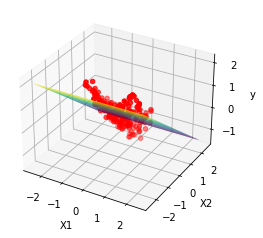
Here is where it fit to the curve a bit better.
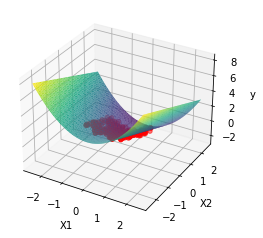

Over fitting is when a machine learning model believes that there exist trends in higher power polynomails. This machine learning model fits to the noise of the data set.

This can happen when in the feature engineering phase and choosing to use higher order polynomials that don't contribute to the actual trend of the data. 
   
Another example where this can happen is when a kNN uses a small number for the number of neighbours it 
considers and therefore if an input lands beside a noisey data point, then the input will be affect a lot by that noise. Since when k is larger, it reduces the effect of the immediate noise.


### (ii)
Assuming we want to get the mean, and variation of the mean squared error of our model gathered over the N folds.
```
given numFolds, and data(X1, X2, ... and Y), Xs columns of inputs, Y column of output, model

meanSquaredErrors = []
testSize = data.size / numFolds 
i from 0 to numFolds-1:
   foldIndices = [(i * testSize) ... ((i+1) * testSize)]
   foldData    = data[foldIndices]
   trainData   = data[ (0...dataSize) NOT foldIndices ]
     pred = model.fit(trainData[Xs], trainData[Y]).predict(foldData[Xs])
     meanSquaredError = mse(pred, foldData[Y])
     meanSquaredErrors.append(meanSquaredError)
return mean(meanSquaredErrors), var(meanSquaredErrors)
```

### (iii)
K-fold lets us most importantly determine if the model is over fitting.   

When a model is overfitting, it is essentially just fitting to the noise of the dataset.  

If we take subsets of the data and train the model that likes to overfit to things on each of the subsets, then the model will vary in what it's parameters will be, and therefore its predictions.    

Knowing that the variance of the mean squared error of the over fitting model will be higher than a non over-fitting model, we can distinguish directly from that which model is overfitting.   

We can plot MSE against a some parameter that might induce overfitting (such as C of the L1 penalty) and also have vertical error bars (the variance).   
  
We do K-fold for each value of C and we plot the results.   
  
From here we can see the point at which the model begins to overfit by seeing where the error bars begin to get bigger.   
  
We can then choose the C just before it begins to overfit, which is the sweet spot as that is the point it's also not underfitting since we have chosen the point just before overfitting.


### (iv) 
#### Logistic Regression:  Pros
Once a logistic regression model is trained, it is just a single set of parameters being multiplied by their corresponding input which is fast.   

Can give you a 


#### Logistic Regression:  Cons
Have to feature enginner to fit to curves. Requires a bit more insight on the nature of the data.


#### kNN classifier:  Pros
Can use a kernel to get a behaviour of a Logistic Regressor on a set of neighbours.  

Have design descision on 3 steps: choosing distance function, choosing K, how to map training data points to a prediction: majority voting, average, weighted combination.  

Good for large datasets which as it makes predictions directly from the dataset.   
  
Don't have to feature engineer to have higher polynomial features.

#### kNN classifier:  Cons
When the number of features is large for a kNN model, then using it to predict takes a long time as it has 
to do a computation for each feature for every data point that the kNN is checking against. Have to be more thoughtful on process of testing which hyperparameters will work.

If not using a regression, then cannot predict trends when the input goes beyond the range of the training set.
   


### (v)
One way kNN can give bad prediciton is from over fitting from choice of parameters:
- When using small K, kNN will only consider small number of neighbours which increases the chance of being influneced by outliers more. 
- If using gaussian weights, and using large value for sigma, then the rate at which it dismisses further neighbours for the output is increased, giving it more attention to close neighbours, which could lead to overfitting if the there is an isolated piece of data and also happens to be outliers.  

Another way is lack of data:
- If using a small amount of data, then even when sigman and k are the most appropriate, it will only give 
  reasonable answer when a prediciton is located wihtin a cluster of data, otherwise it will be noise since the closest piece of data could be far away (therefore not accurate to the current input) and if a data point is close, then the likelihood of it being a single data point is high and therefore is more succeptible to that data points noise.
- If the kNN is not kernelised and if the input is outside of the range of training data, then the model will pick the closest points which will be the same k points the further and further away the input goes and therefore will predict the same output past the range of training data.
  